Imports

In [1]:
from matplotlib import pyplot as plt
from PVModel import PVModel
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

The implementation of the P(V) function for all models is realized as static methods of the PVModel class.

In [2]:
V = np.linspace(0, 10, 500)

P_lin = PVModel.calculate_Plin(V, a=10.0, b=4.0)
P_exp = PVModel.calculate_Pexp(V, P0=3.0, alfa=0.4, V0=0.0)
P_log = PVModel.calculate_Plog(V, Pmax=120.0, beta=1.0, V50=5.0)

Pressure values are smoothed before differentiation using the scipy library and the savgol_filter method.

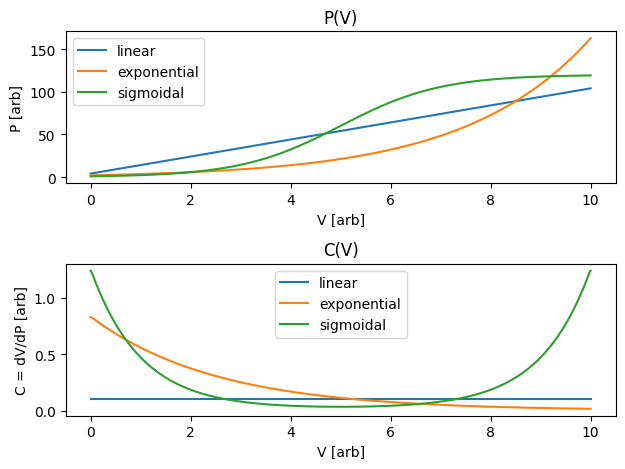

In [3]:
fig, axs = plt.subplots(2)
for P, label in [
    (P_lin, "linear"),
    (P_exp, "exponential"),
    (P_log, "sigmoidal"),
]:
    P_smooth = savgol_filter(P, window_length=11, polyorder=3)
    C = np.gradient(V, P_smooth)
    axs[0].plot(V, P, label=label)
    axs[1].plot(V, C, label=label)

axs[0].set_xlabel("V [arb]")
axs[0].set_ylabel("P [arb]")
axs[0].legend()
axs[0].set_title("P(V)")
axs[1].set_xlabel("V [arb]")
axs[1].set_ylabel("C = dV/dP [arb]")
axs[1].legend()
axs[1].set_title("C(V)")
plt.tight_layout()
plt.show()

Windkessel model – R and C values selected from sample code, the function is also implemented as a PVModel class method.

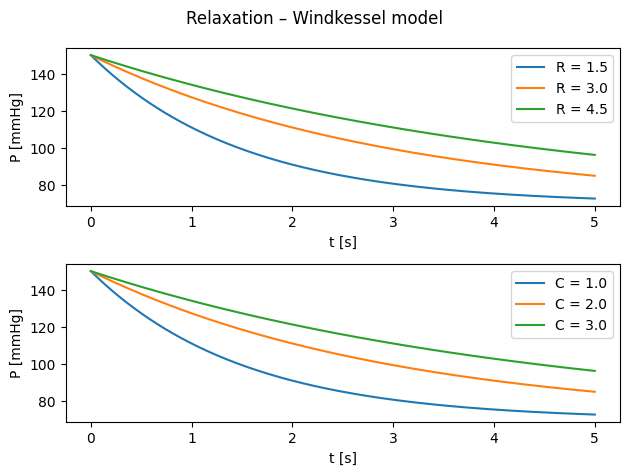

In [4]:
t = np.linspace(0, 5, 500)

R_values = [1.5, 3.0, 4.5]
P_t_R_list = [PVModel.calculate_Windkessel(Pd=70.0, Pi=150.0, R=r, C=1.0, t=t) for r in R_values]

C_values = [1.0, 2.0, 3.0]
P_t_C_list = [PVModel.calculate_Windkessel(Pd=70.0, Pi=150.0, R=1.5, C=c, t=t) for c in C_values]

fig, axs = plt.subplots(2)
for i, P_t in enumerate(P_t_R_list):
    axs[0].plot(t, P_t, label=f"R = {R_values[i]}")

for i, P_t in enumerate(P_t_C_list):
    axs[1].plot(t, P_t, label=f"C = {C_values[i]}")


axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('P [mmHg]')
axs[0].legend()
axs[1].set_xlabel('t [s]')
axs[1].set_ylabel('P [mmHg]')
axs[1].legend()
fig.suptitle('Relaxation – Windkessel model')
plt.tight_layout()
plt.show()



Loading CSV data and presenting it on a scatter plot for initial data evaluation

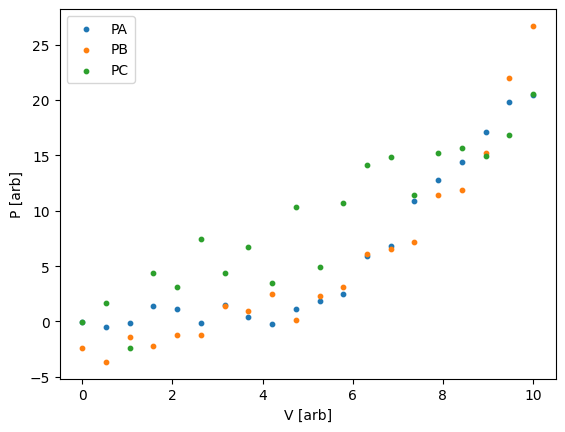

In [5]:
csv_path = "patients.csv"

patients_data = pd.read_csv(csv_path)

for i in range(1, len(patients_data.columns)):
    plt.scatter(patients_data.iloc[:, 0], patients_data.iloc[:, i], label=patients_data.columns[i], s=10)

plt.xlabel('V [arb]')
plt.ylabel('P [arb]')
plt.legend()
plt.show()

Calculate best parameters for every model and evaluate them with R^2 parameter

In [43]:
models_to_fit = [
    PVModel.calculate_Plin,
    PVModel.calculate_Pexp,
    PVModel.calculate_Plog,
]

p0_list = {
    "calculate_Plin": [5.0, 0.0],
    "calculate_Pexp": [2.0, 0.5, 0.0],
    "calculate_Plog": [120.0, -1.0, 5.0]
}
parameters_list = {patients_data.columns[i] : PVModel.fit_and_evaluate(models_to_fit, p0_list, patients_data.iloc[:, 0], patients_data.iloc[:, i]) for i in range(1, len(patients_data.columns))}

for i in range(1, len(patients_data.columns)):
    patient = patients_data.columns[i]
    best_model = getattr(PVModel, parameters_list[patient]["model"])
    r_squared = parameters_list[patient]["r_squared"]
    print(f"For {patient} best model is f{best_model.__name__} with R_squared={r_squared:2f}")

For PA best model is fcalculate_Plog with R_squared=0.989994
For PB best model is fcalculate_Plog with R_squared=0.962207
For PC best model is fcalculate_Plog with R_squared=0.872013


c:\Users\mateu\OneDrive\Pulpit\studia\ib\2 sem\modelowanie procesow fizjologicznych\lab_1\PVModel.py:56: OptimizeWarning: Covariance of the parameters could not be estimated
  params = curve_fit(model, x_data, y_data, p0=p0_list[model.__name__])[0]


Comparition of real and predicted values

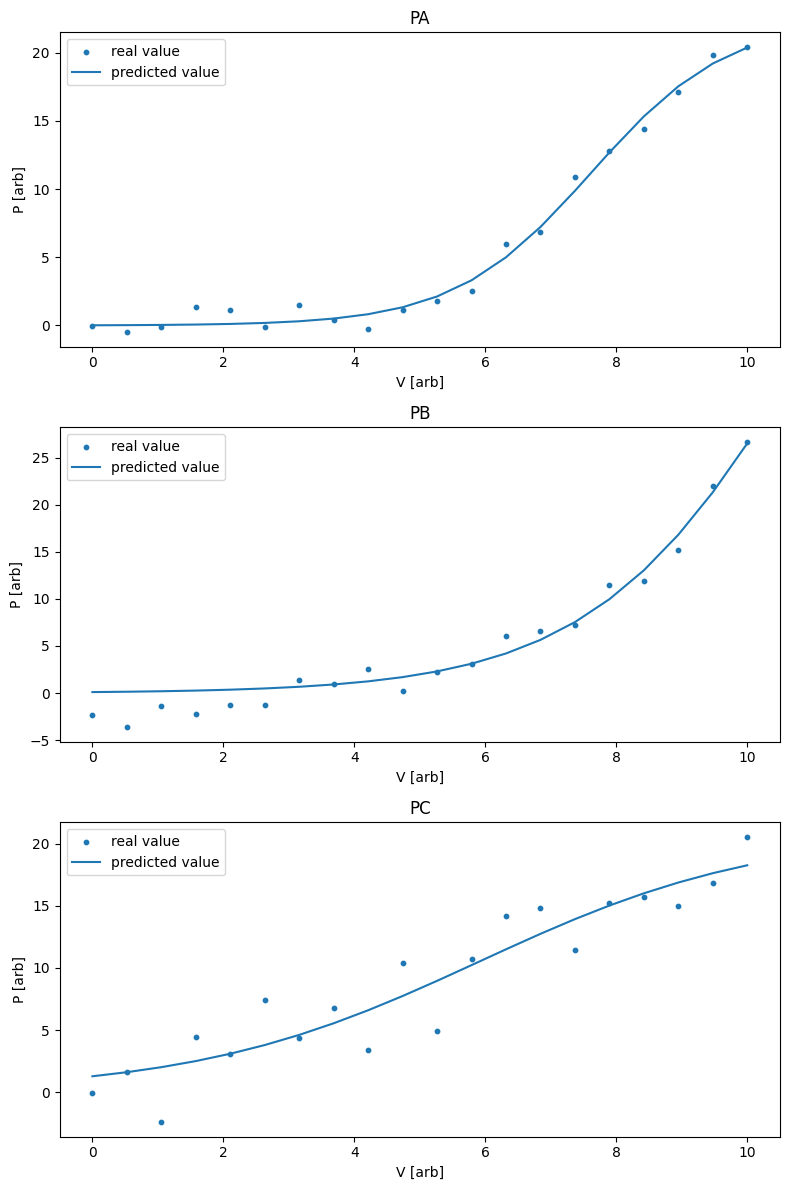

In [7]:
fig, axs = plt.subplots(3, figsize=(8, 12))

for i in range(1, len(patients_data.columns)):
    patient = patients_data.columns[i]
    best_model = getattr(PVModel, parameters_list[patient]["model"])
    params = parameters_list[patient]["parameters"]
    y_predicted = best_model(patients_data.iloc[:, 0], *params)
    axs[i - 1].scatter(patients_data.iloc[:, 0], patients_data.iloc[:, i], label="real value", s=10)
    axs[i - 1].plot(patients_data.iloc[:, 0], y_predicted, label="predicted value")
    axs[i - 1].set_xlabel("V [arb]")
    axs[i - 1].set_ylabel("P [arb]")
    axs[i - 1].legend()
    axs[i - 1].set_title(patient)

plt.tight_layout()
plt.show()

Comparition of C value with different P, becouse best model is linear compliance is constant

In [42]:
P_to_check = [80, 100, 120]
V_c = np.linspace(0, 10, 8000)

for i in range(1, len(patients_data.columns)):
    patient = patients_data.columns[i]
    best_model = getattr(PVModel, parameters_list[patient]["model"])
    params = parameters_list[patient]["parameters"]
    P_c = best_model(V_c, *params)
    k_c = np.gradient(V_c, P_c)
    print(f"For patient {patient}:")
    for p in P_to_check:
        index = np.argmin(np.abs(P_c - p))
        print(f"At P = {p} --> C = {k_c[index]}")


For patient PA:
At P = 80 --> C = 0.5490381324537832
At P = 100 --> C = 0.5490381324537832
At P = 120 --> C = 0.5490381324537832
For patient PB:
At P = 80 --> C = 0.09583910169111803
At P = 100 --> C = 0.09583910169111803
At P = 120 --> C = 0.09583910169111803
For patient PC:
At P = 80 --> C = 0.9034320951351041
At P = 100 --> C = 0.9034320951351041
At P = 120 --> C = 0.9034320951351041


Patient B has the lowest vein compliance, which may be due to cardiovascular disease. The characteristics of the P-V model for patient B also differ from those for patients A and C, i.e., for low volumes, the pressure increase is small, but above a certain value, the increase rises significantly.

Control question: How does a change in R affect the pressure decay constant in the Windkesse model?

An increase in the R coefficient causes a slowdown in pressure decay in the Windkessel model. This can be seen in the Relaxation - Windkessel model graph.